# Multi Modal Semantic Search Data Preparation 

This notebook is used to download, curate/fabricate some media assets required to complete the workshop. In order to achieve sufficient variance within the dataset as well as similar media assets we will be combining some real world images as well as fabricating some images using a Text to Image model.


### Installing required Libraries

The following cells installs the necessary libraries to complete our data preparation. We are also installing a 3rd party library called FiftyOne which is an open-sourced tool for downloading free curated datasets utilised for various computer vision models. Notably the library provides us a programatic interface to query and download open datasets. 

In [1]:
!pip install setuptools==70.1.1
!pip install fiftyone

In [2]:
import sagemaker
import boto3
import json
import pprint as pp
import os
import shutil
import csv
import time
import pprint
import io
import base64
import uuid
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import fiftyone as fo
import fiftyone.zoo as foz
import random

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Load the Dataset

For our exercise we are going to be utilising a small slice of images from the [Google Open Images dataset v7](https://storage.googleapis.com/openimages/web/index.html). The dataset contains labelled assets accross training, validation and test split. We will not be utilising any bounding boxes or class labels for our exercise but generally they can be utilised for traditional ML training purposes. 

For the purposes of this lab we are only interested in a select few classes from the validation set to keep the download to a minimum we are also applying a max_samples flag to 200 images only. The following cells utilises the FiftyOne library to download the dataset and save into disk for subseuqent labs. 


In [3]:
# includes all the available classes in the dataset 
#classes = fo.utils.openimages.get_classes()

fo.config.dataset_zoo_dir = "./data/" # set the location for the dataset download

In [4]:
# preselect some classes as desired
# fiftyone downloads classes and hierarchy metadata but for our use case we will not be needing them.
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    label_types=["points"],
    classes = ["Baseball bat", "Baseball"],
    max_samples=100, # limit to 100 samples but can be increased as desired 
)

Ignoring invalid classes ['Baseball']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`
Only found 18 (<100) samples matching your requirements
 100% |█████████████████████| 18/18 [910.5ms elapsed, 0s remaining, 19.9 files/s]      
Dataset info written to './data/open-images-v7/info.json'
Loading 'open-images-v7' split 'validation'
Ignoring invalid classes ['Baseball']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`
 100% |███████████████████| 18/18 [2.5s elapsed, 0s remaining, 7.3 samples/s]      
Dataset 'open-images-v7-validation-100' created


The following cell implements a simple helper function to display images. 

In [5]:
# helper functions for generating metadata and creating some previews

def display_image(path):
    im = Image.open(path)
    plt.imshow(im)
    plt.figure(figsize=(10, 10))
    plt.show()

## Fabricate dataset using Titan 

Now that we have some images downloaded from the Open Images dataset, we are going to further augment our assets library with some fabricated images. The fabrication is necessary to generate enough similar images for a set topic so that we are able to conduct a semantic similarity search and ephasise the final results of the semantic search for lab purposes.

The fabricated images are generated using [Amazon Titan Image Generator G1 model](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-image-models.html). Amazon Titan Image Generator v1 enables users to generate and edit images in versatile ways. Users can create images that match their text-based descriptions by simply inputting natural language prompts. Furthermore, they can upload and edit existing images, including applying text-based prompts without the need for a mask, or editing specific parts of an image using an image mask. The model also supports outpainting, which extends the boundaries of an image, and inpainting, which fills in missing areas. 

A 2nd LLM, [Anthropic Claude Haiku](https://aws.amazon.com/bedrock/claude/) is utilised in tandem to generate the prompts required to create the images. Haiku is Anthropic's most compact and fastest model and provides the ideal balance of price performance. 


The following cell contains helper function to generate an image using Titan Image Generator model as well as saving the output as image on disk. Since titan returns images in base64 we are required to decode before saving to file.

In addition, we have a 2nd function defined in order to generate sufficient randomisation and variations in the generated images. This is done by calling Haiku to create a series of prompts and negative prompts which we can utilise to generate images. 

In [6]:
# create a series images using titan image generator to augment the dataset with our fabricated images 
# we will leave a set for testing and search purposes later. 
# amazon.titan-image-generator-v1
from botocore.exceptions import ClientError
import logging

boto3_bedrock = boto3.client('bedrock-runtime')

def generate_image(p, seed=1, number_of_images=5):

    logger = logging.getLogger(__name__)
    logging.basicConfig(level=logging.INFO)
    modelId = 'amazon.titan-image-generator-v2:0'
    #modelId="amazon.titan-image-generator-v1",

    response = None
    try: 
        # something 
        # Create payload
        body = json.dumps(
            {
                "taskType": "TEXT_IMAGE",
                "textToImageParams": {
                    "text": p["prompt"],                    # Required
                    "negativeText": p["neg_prompt"]   # Optional
                },
                "imageGenerationConfig": {
                    "numberOfImages": number_of_images,   # Range: 1 to 5 
                    #"quality": "standard",  # Options: standard or premium
                    "height": 512,        # Supported height list in the docs 
                    "width": 512,         # Supported width list in the docs
                    "cfgScale": 7.5,       # Range: 1.0 (exclusive) to 10.0
                    "seed": seed             # Range: 0 to 214783647
                }
            }
        )
        # Make model request
        response = boto3_bedrock.invoke_model(
            body=body,
            modelId=modelId,
            accept="application/json", 
            contentType="application/json"
        )
    except ClientError as err:
        # error state 
        message = err.response["Error"]["Message"]
        logger.error("A client error occurred: %s", message)
        # use a default prompt to generate image 
        defaultprompt = {
            "prompt": "person playing baseball swinging bat to score a home run",
            "neg_prompt": "blurry image"
        }
        # Create payload
        body = json.dumps(
            {
                "taskType": "TEXT_IMAGE",
                "textToImageParams": {
                    "text": defaultprompt["prompt"],                    # Required
                    "negativeText": defaultprompt["neg_prompt"]   # Optional
                },
                "imageGenerationConfig": {
                    "numberOfImages": number_of_images,   # Range: 1 to 5 
                    #"quality": "standard",  # Options: standard or premium
                    "height": 512,        # Supported height list in the docs 
                    "width": 512,         # Supported width list in the docs
                    "cfgScale": 7.5,       # Range: 1.0 (exclusive) to 10.0
                    "seed": seed             # Range: 0 to 214783647
                }
            }
        )
        # Make model request
        response = boto3_bedrock.invoke_model(
            body=body,
            modelId=modelId,
            accept="application/json", 
            contentType="application/json"
        )

    # Process the image payload
    response_body = json.loads(response.get("body").read())
    # img1_b64 = response_body["images"][0] # in bytes IO
    images_b64 = response_body["images"]
    images = []
    
    # save to disk 
    os.makedirs("./data/titan", exist_ok=True)

    for img_b64 in images_b64:
        # Decode + save
        filename = uuid.uuid4()
        img = Image.open(
            io.BytesIO(
                base64.decodebytes(
                    bytes(img_b64, "utf-8")
                )
            )
        )
        img.save("data/titan/{0}.png".format(filename))
        images.append(img)
    
    return images


def generate_image_prompts(messages, max_tokens,top_p,temp):

    model_id = "anthropic.claude-3-haiku-20240307-v1:0" # calling haiku 
    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages,
            "temperature": temp,
            "top_p": top_p
        }  
    )  
    
    response = boto3_bedrock.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
    response_text = response_body["content"][0]["text"]    

    return response_text


### Utilising LLM to create image generation prompts 

In the following cell we are defining a prompt template, instructing the LLM to generate 20 prompts for a given topic as well as providing some guidance on how to output the prompt as JSON array. 

In [7]:
# first let us create a series of prompts and negative prompts using Bedrock Claude 
prompt = """
You are an image prompt generator. Based on the specified comma separated list of topics in the <topics> xml tags, generate a set of text prompts that can be used to generate images using a text to image generative model. 
Each prompt should only be about one topic and must be scoped to sports, or a sporting action. 
Make necessary determination on related subjects and themes based on the topic and be creative with the generated prompts. 
The output should contain a list of prompts as well as corresponding negative prompts as outlined in the <example_output> xml tags. 
All generated output need to follow responsible use of AI practices and all prompts need to avoid questionable, adult, and explicit terms at all times. 
Generate 20 prompts

<topics>{topic}</topics>


The generated prompts will be directly passed to an text to image model so ensure the prompts contain enough details and creative descriptions. 

Output the data as well formed json array only as outlined in the <example_output> XML tags without any newline characters in the output

<example_output> 
[
    { "prompt":"person playing baseball swinging bat to score a home run", "neg_prompt"="blurry image" },
    { "prompt":"person playing baseball at a packed stadium with cheering fans", "neg_prompt"="video game graphics" },
    { "prompt":"baseball player sliding to make a home run, electric atmosphere", "neg_prompt"="do not include baseball bats" },
]
</example_output> 

output: 

[

"""


Execute the prompt generate some prompts to be used for image generation. The topics are supplied via the placeholder "topic" parameter. 

In [8]:
image_prompts = []
request_payload = [
        { "role": "user",
          "content": [
              {"type": "text","text": prompt.replace("{topic}","baseball, soccer, basketball")}
          ]
        }
    ]
response = generate_image_prompts(messages=request_payload,max_tokens=4096,temp=0.5,top_p=0.9) 
image_prompts = json.loads(response)

In [9]:
# lets review the prompts that we have prepared 
pprint.pp(image_prompts)

[{'prompt': 'baseball player pitching a fastball with perfect form on the '
            'mound',
  'neg_prompt': 'blurry image, low quality'},
 {'prompt': 'baseball team celebrating a game-winning hit with high fives and '
            'cheers',
  'neg_prompt': 'cartoon style, 3D render'},
 {'prompt': 'baseball outfielder making a leaping catch at the wall to rob a '
            'home run',
  'neg_prompt': 'out of focus, motion blur'},
 {'prompt': 'youth baseball game with players running the bases and diving '
            'into home plate',
  'neg_prompt': 'computer generated, low resolution'},
 {'prompt': 'baseball umpire making a close call at first base with players in '
            'action',
  'neg_prompt': 'grainy texture, digital artifact'},
 {'prompt': 'baseball stadium filled with fans cheering and waving team flags',
  'neg_prompt': 'empty stadium, no people'},
 {'prompt': 'baseball player hitting a grand slam home run with the ball '
            'soaring over the fence',
  'n

### Generating the images 

Now that we have a series of prompts automatically generated using Claude we are now ready to create some images. 

The following cell invokes the generate_image helper function for each image prompts. In order to complete the task faster we have opted to run this accross 5 threads. 


In [10]:
# Generate series of images using the prompts prepared, we are going to create 5 images per prompt
# approx 30 seconds per set of 5 images - approx 2 mins 

from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(5)

start_time = time.time()
results = pool.map(generate_image, image_prompts)
duration = time.time() - start_time
print(f"Processed {len(image_prompts)} in {duration} seconds")



Processed 20 in 163.88113141059875 seconds


Let us preview a sample image before proceeding. 

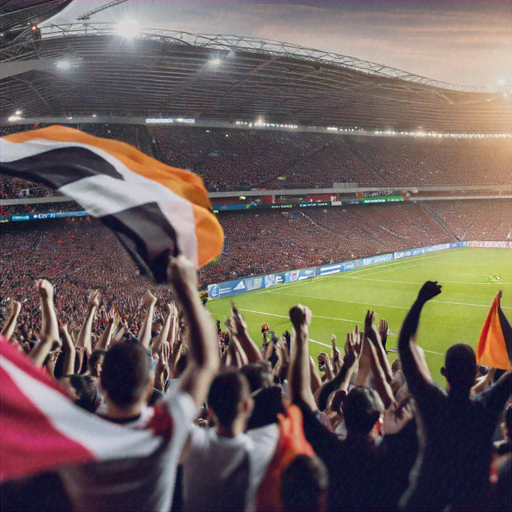

In [12]:
# display a sample image from the fabricated set
results[random.randrange(0,20)][random.randrange(0,4)]

## Combining a curated dataset of open image and fabricated images 

The final step of the data preparation is simply to combine the sample 200 images downloaded from the Open Images dataset and the fabricated images generated using Titan and Haiku. In order to improve ease of access in subsequent notebooks, we are going to be creating a dataframe with various metadata attributes (e.g keywords, description) which we will populate in data enrichment notebook. 

In [13]:
# move all images into curated folder 
os.makedirs("data/curated-images", exist_ok=True)

!cp -a ./data/open-images-v7/validation/data/. ./data/curated-images/
!cp -a ./data/titan/. ./data/curated-images/


In [14]:
# resize and reduce quality of all images to make inferences faster (e.g. titan has a 5MB limit per image) 

from PIL import Image
import os, sys

path = "./data/curated-images/"
resized_path = ".data/resized-images/"
# create resized images folder
os.makedirs("data/resized-images", exist_ok=True)

dirs = os.listdir(path)

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((200,200), Image.Resampling.LANCZOS)
            imResize.save(f.replace("curated-images","resized-images") + ".jpg", 'JPEG', quality=90)

resize()

The following cell creates the dataframe with empty title, descrption, keywords and other metadata fields. We are going to utilise the file name as image_id attribute. 

In [15]:
# load all the images into a single dataset

sample_images = []
images_dir = "./data/resized-images"

for filename in os.listdir(images_dir):
    f = os.path.join(images_dir, filename)
    # checking if it is a file
    if os.path.isfile(f):
        sample_images.append(
            {
                'image_id':filename,
                'path':f,
                'title':'',
                'description':'',
                'tags':[],
                'keywords':[],
                'embeddings':[]
            }
        )

df_images = pd.DataFrame(sample_images)

df_images.head()

,image_id,path,title,description,tags,keywords,embeddings
0,00a7655d4eabf186.jpg,./data/resized-images/00a7655d4eabf186.jpg,,,[],[],[]
1,19aa926f2f7d9782.jpg,./data/resized-images/19aa926f2f7d9782.jpg,,,[],[],[]
2,39209fa476d1430c.jpg,./data/resized-images/39209fa476d1430c.jpg,,,[],[],[]
3,1efc2db85591a04f.jpg,./data/resized-images/1efc2db85591a04f.jpg,,,[],[],[]
4,3c06d149c8027e71.jpg,./data/resized-images/3c06d149c8027e71.jpg,,,[],[],[]


Display image from the dataframe 

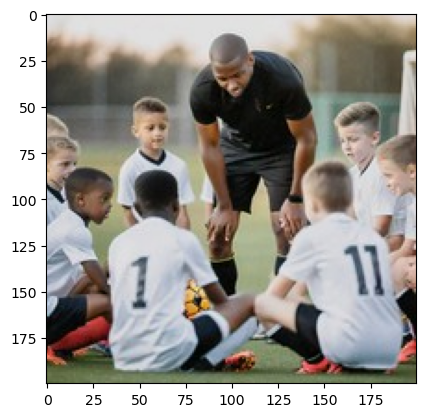

<Figure size 1000x1000 with 0 Axes>

In [16]:
test_image_path = df_images.sample()["path"].values[0]
display_image(test_image_path)

In [17]:
fabricated_images = []

Save the dataframe for use in subsequent notebooks. 

In [18]:
# save for use in next notebook 
%store df_images

Stored 'df_images' (DataFrame)


In [19]:
df_images.shape

(107, 7)

In [ ]:
# uncomment below line to delete the dataset
#foz.delete_zoo_dataset("open-images-v7", split="validation")